In [1]:
import pandas as pd
import cv2 as cv
import os
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score

### Load CSV

In [2]:
file_path = './images'
csvf_path = './multilabel_classification(6)-reduced_modified.csv'

In [3]:
df = pd.read_csv(csvf_path)

In [4]:
df.head()

,Image_Name,"Classes(motorcycle, truck, boat, bus, cycle, , , , , , , sitar, ektara, flutes, tabla, harmonium)",motorcycle,truck,boat,bus,cycle,sitar,ektara,flutes,tabla,harmonium
0,image1.jpg,bus,0,0,0,1,0,0,0,0,0,0
1,image2.jpg,sitar,0,0,0,0,0,1,0,0,0,0
2,image3.jpg,flutes,0,0,0,0,0,0,0,1,0,0
3,image4.jpg,bus,0,0,0,1,0,0,0,0,0,0
4,image5.jpg,bus,0,0,0,1,0,0,0,0,0,0


In [5]:
duplicate_rows = df[df.duplicated()]

In [6]:
print(duplicate_rows)

Empty DataFrame
Columns: [Image_Name,  Classes(motorcycle, truck, boat, bus, cycle, , , , , , , sitar, ektara, flutes, tabla, harmonium), motorcycle, truck, boat, bus, cycle, sitar, ektara, flutes, tabla, harmonium]
Index: []


In [7]:
source_folder = './images'

In [8]:
def read_images(df):
    image_list = []
    label_list = []

    for index, row in df.iterrows():
        image_name = row['Image_Name']
        image_path = os.path.join(source_folder, image_name)
        if os.path.exists(image_path):
            # Load the image if it exists
            image = cv.imread(image_path)
            resized_image = cv.resize(image, (112, 112))
            normalized_image = resized_image / 255.0

            image_list.append(normalized_image)

            label_list.append(row[1].split())
        else:
            # Print a message if the image doesn't exist
            print(f"Image '{image_name}' not found in '{source_folder}'")

    mlb = MultiLabelBinarizer()
    label_list = mlb.fit_transform(label_list)

    return image_list, label_list

In [9]:
# image_list, label_list = read_images(df)

In [10]:
# images_list = np.array(image_list)
# labels_list = np.array(label_list)

In [11]:
# np.save('./images.npy', images_list)
# np.save('./labels.npy', labels_list)

In [12]:
images_list = np.load('./images.npy')
labels_list = np.load('./labels.npy')

### CNN

In [13]:
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

In [14]:
early_stopping = EarlyStopping(monitor='val_loss',  # Monitor validation loss
                               patience=5,         # Number of epochs with no improvement after which training will be stopped
                               restore_best_weights=True)  # Restore model weights from the epoch with the best performance on the validation set

In [15]:
X_train, X_test, y_train, y_test = train_test_split(images_list, labels_list, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [16]:
model = models.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(112, 112, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),

    layers.Dense(10, activation='softmax')
])


# Compile the model
model.compile(optimizer=optimizers.Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 110, 110, 64)      1792      
                                                                 
 batch_normalization (Batch  (None, 110, 110, 64)      256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 55, 55, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 53, 53, 64)        36928     
                                                                 
 batch_normalization_1 (Bat  (None, 53, 53, 64)        256       
 chNormalization)                                                
                                                      

In [17]:
import matplotlib.pyplot as plt

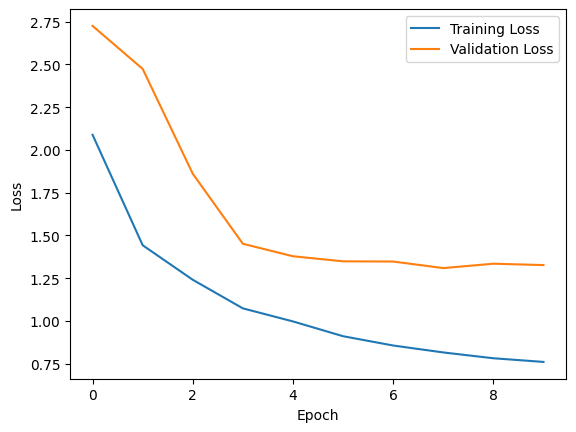

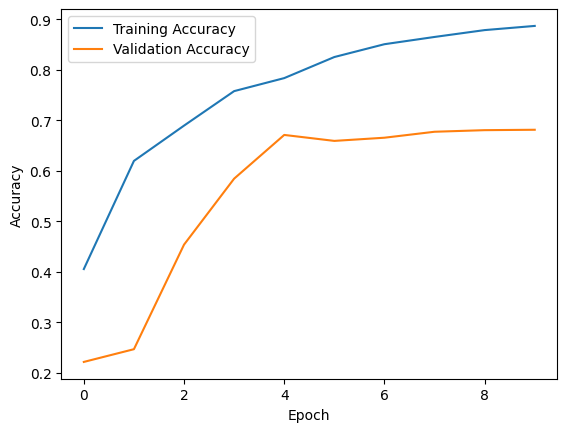

In [18]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [34]:
y_pred_prob = model.predict(X_test)

50/50 [==============================] - 6s 121ms/step


In [38]:
y_pred_binary_05 = (y_pred_prob >= 0.5).astype(int)
y_pred_binary_04 = (y_pred_prob >= 0.4).astype(int)
y_pred_binary_03 = (y_pred_prob >= 0.3).astype(int)

In [39]:
print(f'Acc at 0.5 threshold: {accuracy_score(y_test, y_pred_binary_05)}')
print(f'Acc at 0.4 threshold: {accuracy_score(y_test, y_pred_binary_04)}')
print(f'Acc at 0.3 threshold: {accuracy_score(y_test, y_pred_binary_03)}')

Acc at 0.5 threshold: 0.4726242920075519
Acc at 0.4 threshold: 0.5575833857772183
Acc at 0.3 threshold: 0.6110761485210825
